Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: suryabharadwaj123
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ericanacletoribeiro/cicids2017-cleaned-and-preprocessed


100%|██████████| 200M/200M [00:00<00:00, 1.04GB/s]




Loading cicids2017-cleaned-and-preprocessed/cicids2017_cleaned.csv...
Target Column: Attack Type
Class Weights: {0: np.float64(184.78878401905985), 1: np.float64(39.3559718969555), 2: np.float64(2.8130348720910283), 3: np.float64(1.8586654770814361), 4: np.float64(0.1718842359755939), 5: np.float64(3.9705838920228005), 6: np.float64(168.07801300216704)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.7480 - loss: 0.5778 - val_accuracy: 0.8681 - val_loss: 0.3264
Epoch 2/15
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.8636 - loss: 0.1733 - val_accuracy: 0.9011 - val_loss: 0.2907
Epoch 3/15
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.8856 - loss: 0.1336 - val_accuracy: 0.8718 - val_loss: 0.3115
Epoch 4/15
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - accuracy: 0.8899 - loss: 0.1234 - val_accuracy: 0.8811 - val_loss: 0.3046
Epoch 5/15
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accuracy: 0.8992 - loss: 0.1078 - val_accuracy: 0.9144 - val_loss: 0.2101
Epoch 6/15
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.9035 - loss: 0.1051 - val_accuracy: 0.9074 - val_loss: 0.2585
Epoch 7/15
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.9068 - loss: 0.1069 - val_accuracy: 0.9166 - val_loss: 0.2062
Epoch 8/15
1576/1576 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.9131 -

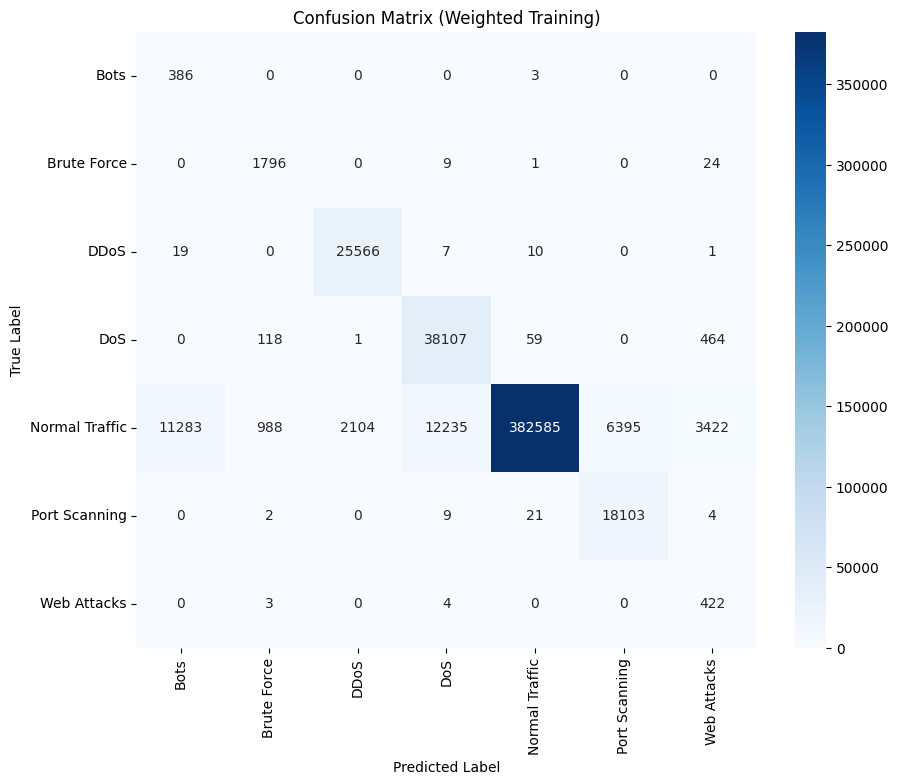

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

Sample Check (Index 10):
Predicted: Normal Traffic
Actual:    Normal Traffic


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Libraries for Kaggle Download
try:
    import opendatasets as od
except ImportError:
    import os
    os.system('pip install opendatasets')
    import opendatasets as od

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models

# ==========================================
# 1. AUTO-DOWNLOAD DATA FROM KAGGLE
# ==========================================
# This specific dataset contains the 'cicids2017_cleaned.csv' file
dataset_url = 'https://www.kaggle.com/datasets/ericanacletoribeiro/cicids2017-cleaned-and-preprocessed'

print("Downloading dataset from Kaggle... (Enter credentials if prompted)")
od.download(dataset_url)

# The download creates a folder named after the dataset
data_dir = 'cicids2017-cleaned-and-preprocessed'
filename = 'cicids2017_cleaned.csv'
file_path = os.path.join(data_dir, filename)

# ==========================================
# 2. LOAD & PREPROCESS
# ==========================================
print(f"\nLoading {file_path}...")
df = pd.read_csv(file_path)

# Verify target column name
target_col = "Attack Type"
if target_col not in df.columns:
    # Fallback if column names differ
    target_col = "Label" if "Label" in df.columns else df.columns[-1]

print(f"Target Column: {target_col}")

y = df[target_col]
X = df.drop(target_col, axis=1)

# Encode labels
enc = LabelEncoder()
y_enc = enc.fit_transform(y)

# Stratified Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ==========================================
# 3. COMPUTE CLASS WEIGHTS (Fixes Accuracy Trap)
# ==========================================
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# ==========================================
# 4. BUILD MODEL
# ==========================================
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_enc))

model = models.Sequential([
    layers.Dense(256, activation="relu", input_shape=(input_dim,)),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# ==========================================
# 5. TRAIN
# ==========================================
history = model.fit(
    X_train, y_train,
    epochs=15,               # Reduced slightly for speed
    batch_size=1024,
    validation_split=0.2,
    class_weight=class_weights_dict,  # <--- Critical for detecting attacks
    verbose=1
)

# ==========================================
# 6. EVALUATION
# ==========================================
pred_probs = model.predict(X_test)
pred_labels = np.argmax(pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, pred_labels, target_names=enc.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues", xticklabels=enc.classes_, yticklabels=enc.classes_, annot=True, fmt='d')
plt.title("Confusion Matrix (Weighted Training)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# ==========================================
# 7. SINGLE SAMPLE CHECK
# ==========================================
# Fixed the 'label_encoder' vs 'enc' variable bug
test_idx = 10
test_item = X_test[test_idx].reshape(1, -1)
pred_class = np.argmax(model.predict(test_item))
actual_class = y_test[test_idx]

print(f"\nSample Check (Index {test_idx}):")
print(f"Predicted: {enc.inverse_transform([pred_class])[0]}")
print(f"Actual:    {enc.inverse_transform([actual_class])[0]}")

In [2]:
import joblib

# Save the trained model
model.save('my_model.h5')

# Save the scaler (Crucial! The UI needs this to process new data)
joblib.dump(scaler, 'scaler.pkl')

# Save the class names (To convert 0,1,2 back to "DoS", "Normal", etc.)
np.save('classes.npy', enc.classes_)

# Create a small demo file to test the UI later
# This saves the first 50 rows of your data to a CSV
df.drop("Attack Type", axis=1).head(50).to_csv("demo_traffic.csv", index=False)

print("✅ All files saved successfully!")

✅ All files saved successfully!


In [3]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import os

# --- PAGE CONFIG ---
st.set_page_config(page_title="Traffic Sentinel", layout="centered")

# --- LOAD ASSETS ---
@st.cache_resource
def load_assets():
    # Load model and scaler only once
    try:
        model = tf.keras.models.load_model('my_model.h5')
        scaler = joblib.load('scaler.pkl')
        class_names = np.load('classes.npy', allow_pickle=True)
        return model, scaler, class_names
    except:
        return None, None, None

model, scaler, class_names = load_assets()

st.title("🛡️ Encrypted Traffic Analysis")

if model is None:
    st.error("Model files not found. Run the training script first!")
    st.stop()

# --- INPUT SECTION ---
st.write("### 1. Upload Traffic Data")
uploaded_file = st.file_uploader("Choose a CSV file", type=['csv'])

# Use demo file if nothing uploaded
if uploaded_file is None and os.path.exists("demo_traffic.csv"):
    st.info("No file uploaded. Using 'demo_traffic.csv' automatically.")
    df = pd.read_csv("demo_traffic.csv")
elif uploaded_file:
    df = pd.read_csv(uploaded_file)
    st.success("File uploaded successfully.")
else:
    df = None

# --- ANALYSIS SECTION ---
if df is not None:
    # Prepare input
    if "Attack Type" in df.columns:
        X_input = df.drop("Attack Type", axis=1)
    else:
        X_input = df

    st.write(f"Loaded {len(X_input)} packets.")

    if st.button("RUN ANALYSIS"):
        # NO progress bars, NO animations - just do the work instantly
        try:
            # 1. Scale
            X_scaled = scaler.transform(X_input)

            # 2. Predict
            preds = model.predict(X_scaled)
            pred_classes = np.argmax(preds, axis=1)
            pred_names = [class_names[i] for i in pred_classes]

            # 3. Results
            results = df.copy()
            results['Prediction'] = pred_names

            st.success("Done!")

            # Summary
            st.write("### Results Summary")
            st.bar_chart(results['Prediction'].value_counts())

            # Detailed View
            st.write("### Detailed Logs")
            st.dataframe(results.head(10))

        except Exception as e:
            st.error(f"Error: {e}")

Writing app.py


In [4]:
import os
import time

# 1. Force kill the process using shell commands
print("🛑 Executing forced shutdown of ngrok...")
get_ipython().system('pkill -9 ngrok')
time.sleep(3)  # Wait for the system to register the death

# 2. Check if it's actually dead
# This command lists any running ngrok processes. If it prints nothing, it worked.
print("🔎 Checking for survivors (should be empty below):")
get_ipython().system('ps -ef | grep ngrok')

print("\n✅ If the list above is empty (or just shows 'grep'), you are ready to start.")

🛑 Executing forced shutdown of ngrok...
🔎 Checking for survivors (should be empty below):
root        4558    1406  0 11:14 ?        00:00:00 /bin/bash -c ps -ef | grep ngrok
root        4560    4558  0 11:14 ?        00:00:00 grep ngrok

✅ If the list above is empty (or just shows 'grep'), you are ready to start.


In [ ]:
from pyngrok import ngrok
import subprocess
import time

# 1. Start Streamlit in the background
print("🚀 Starting Streamlit...")
# We use a slight delay to ensure the port is open before ngrok tries to grab it
proc = subprocess.Popen(["streamlit", "run", "app.py"])
time.sleep(3)

# 2. Open the Tunnel
print("🔗 connecting to ngrok...")
try:
    public_url = ngrok.connect(8501)
    print(f"\n✅ SUCCESS! Click here to open your app:\n{public_url}")
except Exception as e:
    print(f"\n❌ Error: {e}")
    print("\n👇 IF YOU SEE 'ERR_NGROK_334' AGAIN:")
    print("It means Ngrok's servers still think you are online.")
    print("Go to this link and click 'Stop' on the active session:")
    print("👉 https://dashboard.ngrok.com/tunnels/agents")

ModuleNotFoundError: No module named 'pyngrok'

In [ ]:
import pandas as pd

# 1. Load your original data (if not already loaded)
# df = pd.read_csv('cicids2017_cleaned.csv')

# 2. Separate Normal and Attack traffic
normal_traffic = df[df["Attack Type"] == "Normal Traffic"]
attack_traffic = df[df["Attack Type"] != "Normal Traffic"]

# 3. Create a "Hacker Scenario" Dataset
# We pick 20 normal packets and 20 malicious packets randomly
sample_normal = normal_traffic.sample(n=20, random_state=99)
sample_attack = attack_traffic.sample(n=20, random_state=99)

# 4. Combine and Shuffle
new_test_set = pd.concat([sample_normal, sample_attack])
new_test_set = new_test_set.sample(frac=1).reset_index(drop=True)

# 5. Save WITHOUT the target label (Simulating real incoming traffic)
# The UI needs features only, so we drop "Attack Type"
new_test_set_clean = new_test_set.drop("Attack Type", axis=1)
new_test_set_clean.to_csv("new_test_scenario.csv", index=False)

# 6. Save the Answer Key (Optional, to check yourself)
new_test_set[["Attack Type"]].to_csv("answer_key.csv", index=False)

print("✅ Created 'new_test_scenario.csv' with 40 mixed packets!")

NameError: name 'df' is not defined